In [1]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from PIL import Image
import torch
import imageio
import shutil
from sam2.build_sam import build_sam2_video_predictor

In [2]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5, min_tracking_confidence=0.5)

I0000 00:00:1739512023.869118 45130424 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M3


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1739512023.892072 45130546 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1739512023.899373 45130551 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [3]:
def extract_all_frames(video_path, output_dir, target_fps = 10, scale_factor=0.3):
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Could not open video file: {video_path}")
    
    # Get the original FPS of the video
    original_fps = cap.get(cv2.CAP_PROP_FPS)
    if original_fps <= 0:
        raise ValueError("Unable to determine the original FPS of the video.")

    # Calculate the frame interval based on the target FPS
    frame_interval = int(round(original_fps / target_fps))
    if frame_interval < 1:
        frame_interval = 1  # Ensure at least 1 frame is skipped

    frame_count = 0
    saved_frame_count = 0

    
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Save frames at the specified interval
        if frame_count % frame_interval == 0:
            # Resize the frame if scale_factor is provided
            if scale_factor != 1.0:
                frame = cv2.resize(frame, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_AREA)

            # Save the frame
            frame_filename = os.path.join(output_dir, f"{saved_frame_count:04d}.jpg")
            cv2.imwrite(frame_filename, frame)
            saved_frame_count += 1

        frame_count += 1

    cap.release()
    print(f"Extracted {saved_frame_count} frames to {output_dir} at {target_fps} FPS.")

In [4]:
# Load YOLO
net = cv2.dnn.readNet("../yolov3.weights", "../yolov3.cfg")
with open("../coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]
layer_names = net.getUnconnectedOutLayersNames()

# Filter for bowl and wine glass
target_classes = ['bowl', 'wine glass', 'cup', 'bottle']
target_class_ids = [classes.index(cls) for cls in target_classes]

In [5]:
device = torch.device("cpu")

In [6]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

Reposition2
Extracted 7 frames to Reposition2_dir at 10 FPS.


W0000 00:00:1739512038.611007 45130550 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


Best Frame: 4
Total Detections: 4
Number of Hands Detected: 2
Number of Objects Detected: 2
Fingertip Positions for All Hands:
Hand 1 Fingertips: [(393.8039059638977, 405.75246518850327), (399.72264897823334, 415.88864624500275), (399.93112099170685, 423.6290315389633), (393.7000333070755, 424.4302453994751), (376.4318286180496, 424.5478445291519)]
Hand 2 Fingertips: [(439.57709312438965, 414.0632738471031), (459.47036468982697, 440.6937466263771), (460.42965388298035, 441.4998677968979), (464.25640976428986, 440.66788774728775), (468.01644551754, 438.93507838249207)]
Detected Objects:
cup: Center coordinates = (509, 461), Confidence = 0.90
bowl: Center coordinates = (373, 443), Confidence = 0.66
Successfully loaded best frame: Reposition2_dir/0004.jpg
Hand 1 Finger Tips Coordinates:
[(393.8039059638977, 405.75246518850327), (399.72264897823334, 415.88864624500275), (399.93112099170685, 423.6290315389633), (393.7000333070755, 424.4302453994751), (376.4318286180496, 424.5478445291519)]


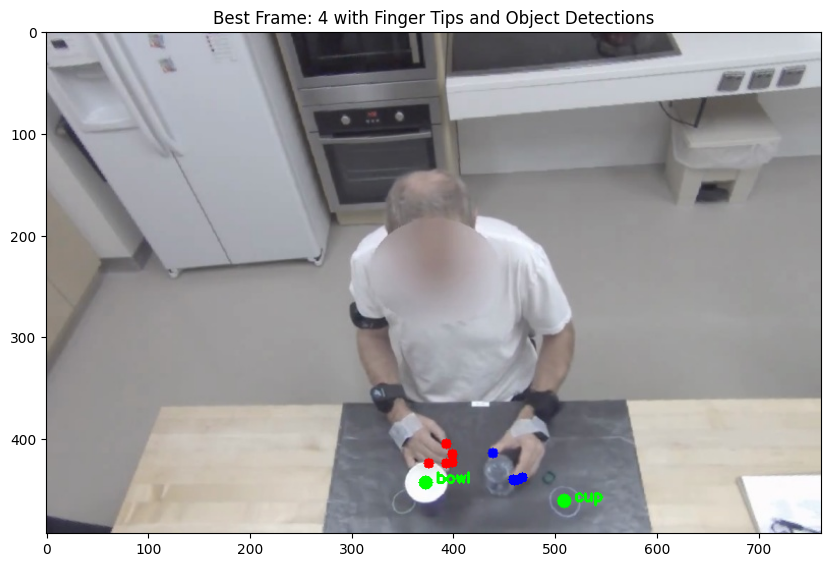

frame loading (JPEG): 100%|██████████| 7/7 [00:00<00:00, 40.79it/s]
/Users/sudharshanramesh/Studies/Curiosity_New/HandTracker/sam2/sam2/sam2_video_predictor.py:786: UserWarning: cannot import name '_C' from 'sam2' (/Users/sudharshanramesh/Studies/Curiosity_New/HandTracker/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


[[509. 461.]] [1]
[[373. 443.]] [1]


propagate in video: 100%|██████████| 5/5 [00:30<00:00,  6.20s/it]
/var/folders/p4/8ylcj22s0jscrsjzklw073mm0000gn/T/ipykernel_27920/1339953003.py:322: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame_path)


Video saved to output_video_Reposition2.mp4
Directory 'temp_frames_Reposition2' and all its contents have been deleted.
Directory 'Reposition2_dir' and all its contents have been deleted.
Reposition3
Extracted 8 frames to Reposition3_dir at 10 FPS.
Best Frame: 0
Total Detections: 4
Number of Hands Detected: 2
Number of Objects Detected: 2
Fingertip Positions for All Hands:
Hand 1 Fingertips: [(395.2593948841095, 408.80857330560684), (400.08413672447205, 414.26171135902405), (400.30005741119385, 424.620513856411), (392.9267792701721, 428.58218228816986), (376.69369035959244, 426.4004275202751)]
Hand 2 Fingertips: [(439.5675097703934, 428.74330073595047), (469.15740966796875, 461.7455776333809), (458.8294154405594, 464.79757183790207), (460.4592214822769, 463.5714495778084), (465.0500568151474, 458.6980793476105)]
Detected Objects:
cup: Center coordinates = (509, 461), Confidence = 0.69
bowl: Center coordinates = (347, 438), Confidence = 0.51
Successfully loaded best frame: Reposition3_d

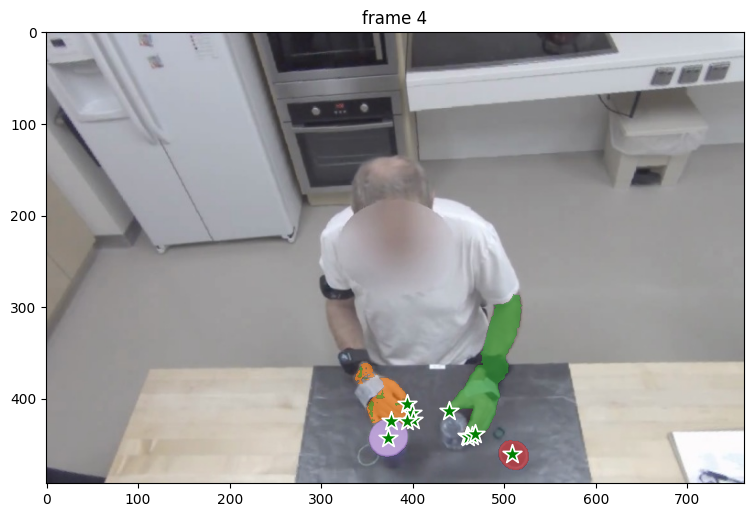

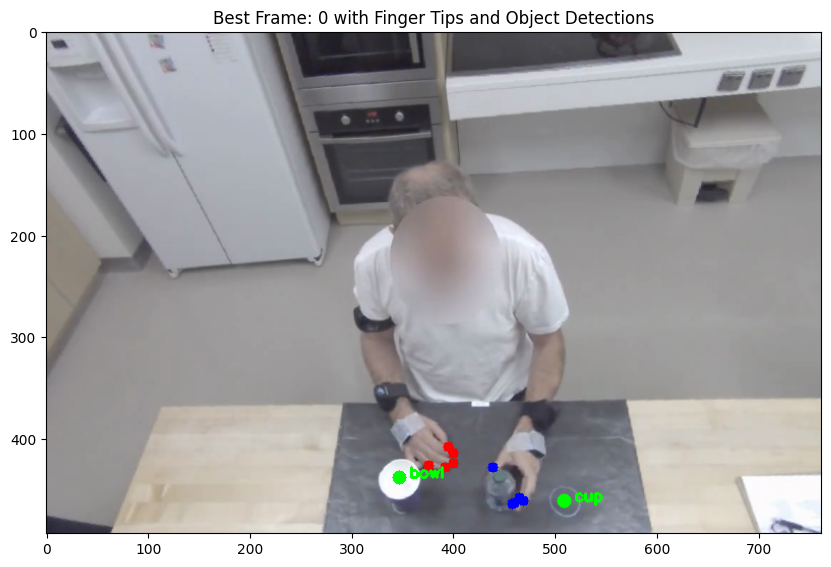

frame loading (JPEG): 100%|██████████| 8/8 [00:00<00:00, 42.42it/s]


[[509. 461.]] [1]
[[347. 438.]] [1]


propagate in video: 100%|██████████| 8/8 [00:52<00:00,  6.52s/it]
propagate in video: 0it [00:00, ?it/s]


Video saved to output_video_Reposition3.mp4
Directory 'temp_frames_Reposition3' and all its contents have been deleted.
Directory 'Reposition3_dir' and all its contents have been deleted.
Stabilize
Extracted 18 frames to Stabilize_dir at 10 FPS.
Best Frame: 17
Total Detections: 4
Number of Hands Detected: 2
Number of Objects Detected: 2
Fingertip Positions for All Hands:
Hand 1 Fingertips: [(530.1649780273438, 149.9914219379425), (543.619758605957, 201.3480362892151), (560.7189483642578, 211.28094720840454), (582.0944442749023, 207.44756841659546), (605.4507064819336, 195.13286232948303)]
Hand 2 Fingertips: [(270.7121238708496, 225.5623004436493), (207.8492431640625, 260.1125020980835), (186.10072135925293, 259.085168838501), (177.52064514160156, 252.87604808807373), (172.77483558654785, 242.56561517715454)]
Detected Objects:
cup: Center coordinates = (235, 246), Confidence = 0.96
bowl: Center coordinates = (587, 256), Confidence = 0.88
Successfully loaded best frame: Stabilize_dir/001

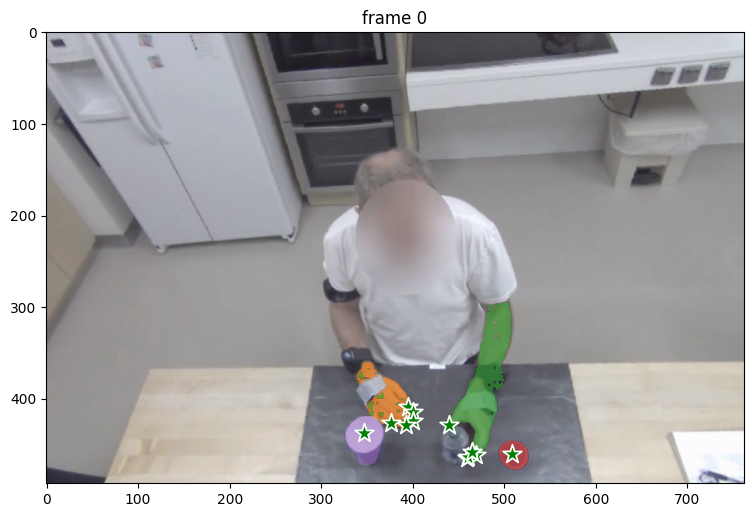

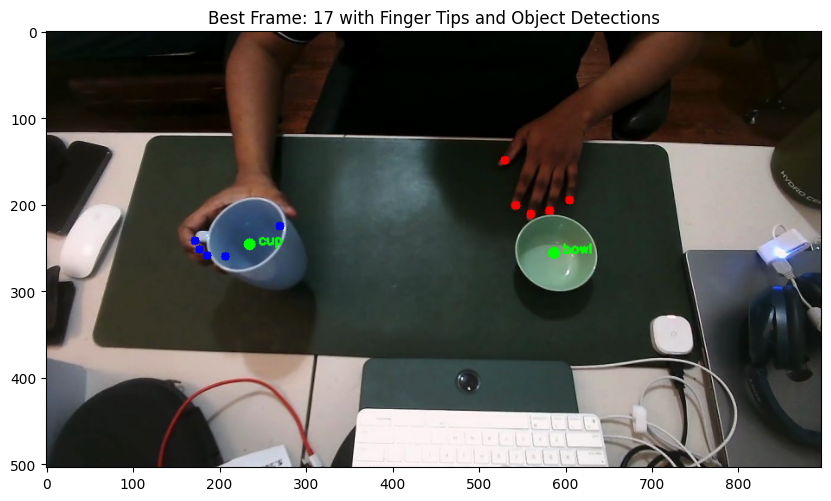

frame loading (JPEG): 100%|██████████| 18/18 [00:00<00:00, 39.01it/s]


[[235. 246.]] [1]
[[587. 256.]] [1]


propagate in video: 100%|██████████| 18/18 [02:24<00:00,  8.03s/it]


Video saved to output_video_Stabilize.mp4
Directory 'temp_frames_Stabilize' and all its contents have been deleted.
Directory 'Stabilize_dir' and all its contents have been deleted.
Transport
Extracted 51 frames to Transport_dir at 10 FPS.
Best Frame: 2
Total Detections: 4
Number of Hands Detected: 2
Number of Objects Detected: 2
Fingertip Positions for All Hands:
Hand 1 Fingertips: [(529.67578125, 150.01345682144165), (543.7603759765625, 201.48315954208374), (561.1432037353516, 210.80229306221008), (581.8197250366211, 207.19925165176392), (605.3623733520508, 195.0743579864502)]
Hand 2 Fingertips: [(284.96003341674805, 218.21212720870972), (196.0832862854004, 256.2013478279114), (187.30184364318848, 262.4148244857788), (184.6091651916504, 259.5220513343811), (180.62884712219238, 253.214186668396)]
Detected Objects:
cup: Center coordinates = (243, 249), Confidence = 0.95
bowl: Center coordinates = (587, 256), Confidence = 0.86
Successfully loaded best frame: Transport_dir/0002.jpg
Hand 

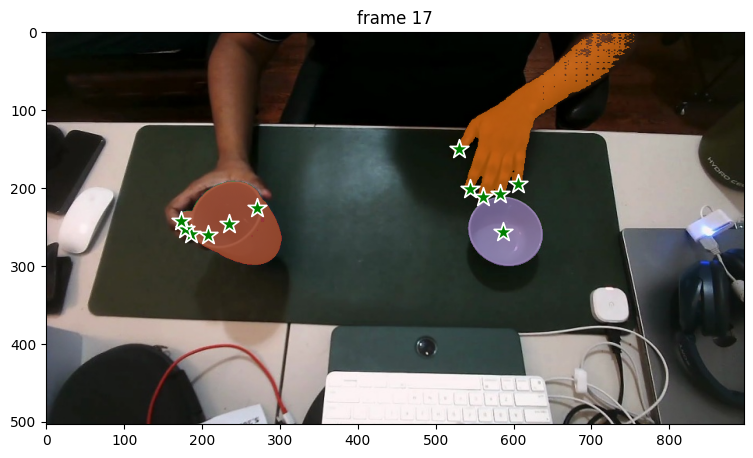

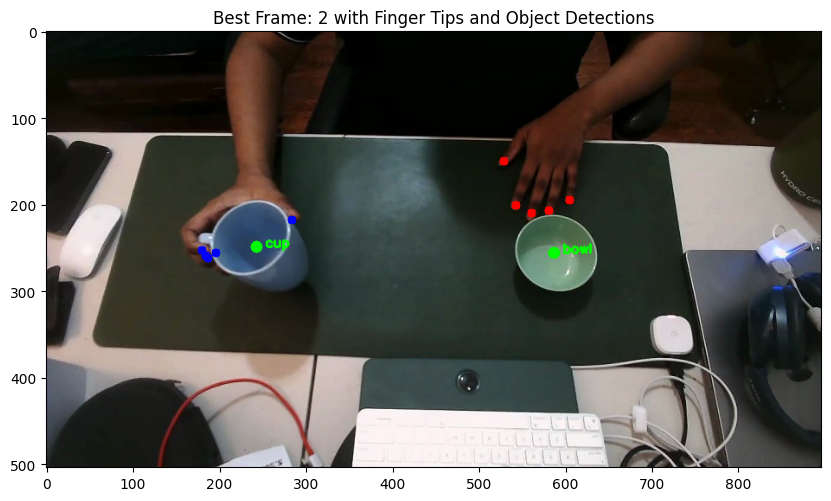

frame loading (JPEG): 100%|██████████| 51/51 [00:00<00:00, 66.44it/s]


[[243. 249.]] [1]
[[587. 256.]] [1]


propagate in video: 100%|██████████| 3/3 [00:17<00:00,  5.83s/it]


Video saved to output_video_Transport.mp4
Directory 'temp_frames_Transport' and all its contents have been deleted.
Directory 'Transport_dir' and all its contents have been deleted.
Reposition
Extracted 38 frames to Reposition_dir at 10 FPS.
Best Frame: 14
Total Detections: 4
Number of Hands Detected: 2
Number of Objects Detected: 2
Fingertip Positions for All Hands:
Hand 1 Fingertips: [(529.9091110229492, 150.70915532112122), (543.6324691772461, 200.50883316993713), (560.4472198486328, 211.1239092350006), (581.7647705078125, 207.20329213142395), (606.5249633789062, 194.79829859733582)]
Hand 2 Fingertips: [(274.2745819091797, 248.6886842250824), (179.95728302001953, 280.02605867385864), (173.7531223297119, 282.882061958313), (172.43194389343262, 275.4954342842102), (168.05056190490723, 267.832311630249)]
Detected Objects:
bowl: Center coordinates = (588, 257), Confidence = 0.82
cup: Center coordinates = (225, 275), Confidence = 0.81
Successfully loaded best frame: Reposition_dir/0014.j

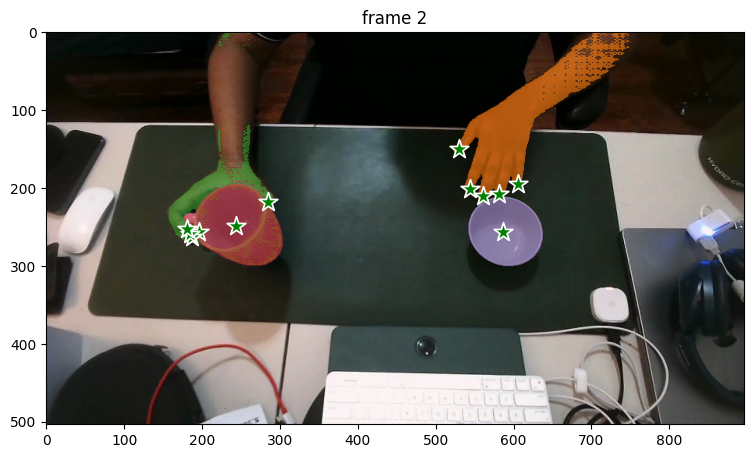

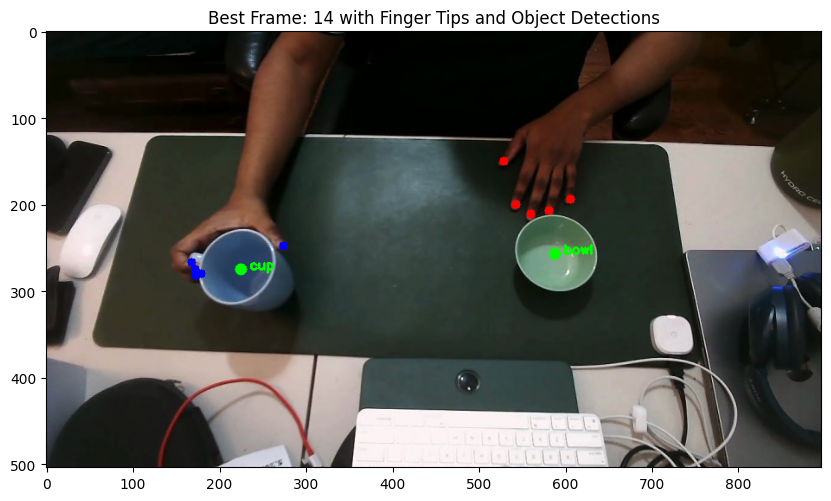

frame loading (JPEG): 100%|██████████| 38/38 [00:00<00:00, 63.70it/s]


[[588. 257.]] [1]
[[225. 275.]] [1]


propagate in video: 100%|██████████| 15/15 [02:06<00:00,  8.45s/it]


Video saved to output_video_Reposition.mp4
Directory 'temp_frames_Reposition' and all its contents have been deleted.
Directory 'Reposition_dir' and all its contents have been deleted.
Idle
Extracted 21 frames to Idle_dir at 10 FPS.
Best Frame: 0
Total Detections: 4
Number of Hands Detected: 2
Number of Objects Detected: 2
Fingertip Positions for All Hands:
Hand 1 Fingertips: [(530.1361389160156, 149.51934671401978), (543.5312118530273, 200.61649918556213), (561.0214920043945, 211.10837817192078), (582.1231231689453, 206.76954889297485), (604.8150177001953, 194.18124675750732)]
Hand 2 Fingertips: [(350.0039520263672, 170.8522982597351), (316.84631729125977, 222.61643028259277), (287.7619934082031, 230.63941097259521), (269.0659980773926, 221.34889125823975), (252.4035873413086, 201.6419699192047)]
Detected Objects:
bowl: Center coordinates = (588, 257), Confidence = 0.92
bowl: Center coordinates = (230, 272), Confidence = 0.59
Successfully loaded best frame: Idle_dir/0000.jpg
Hand 1 Fi

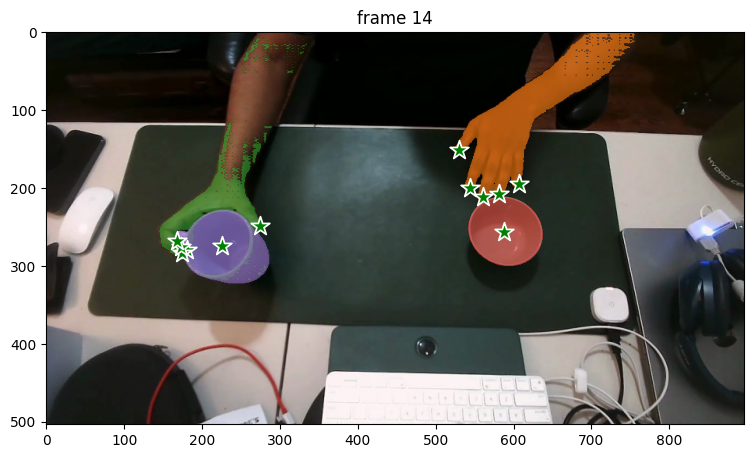

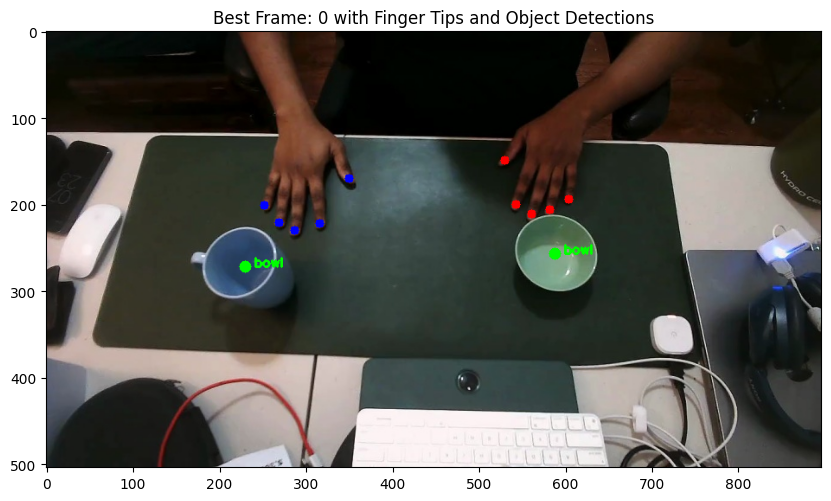

frame loading (JPEG): 100%|██████████| 21/21 [00:00<00:00, 38.47it/s]


[[588. 257.]] [1]
[[230. 272.]] [1]


propagate in video: 100%|██████████| 21/21 [02:52<00:00,  8.22s/it]
propagate in video: 0it [00:00, ?it/s]


Video saved to output_video_Idle.mp4
Directory 'temp_frames_Idle' and all its contents have been deleted.
Directory 'Idle_dir' and all its contents have been deleted.
Reach
Extracted 18 frames to Reach_dir at 10 FPS.
Best Frame: 12
Total Detections: 4
Number of Hands Detected: 2
Number of Objects Detected: 2
Fingertip Positions for All Hands:
Hand 1 Fingertips: [(529.8864669799805, 150.32415318489075), (543.5453109741211, 200.99538803100586), (561.8259963989258, 210.8261754512787), (582.0704650878906, 207.49034643173218), (605.7271881103516, 194.914856672287)]
Hand 2 Fingertips: [(286.42417907714844, 245.42689061164856), (178.71705436706543, 283.69511461257935), (187.70525741577148, 301.9008550643921), (186.80857467651367, 297.26571893692017), (177.50957679748535, 283.36550760269165)]
Detected Objects:
bowl: Center coordinates = (587, 257), Confidence = 0.86
cup: Center coordinates = (234, 274), Confidence = 0.84
Successfully loaded best frame: Reach_dir/0012.jpg
Hand 1 Finger Tips Coo

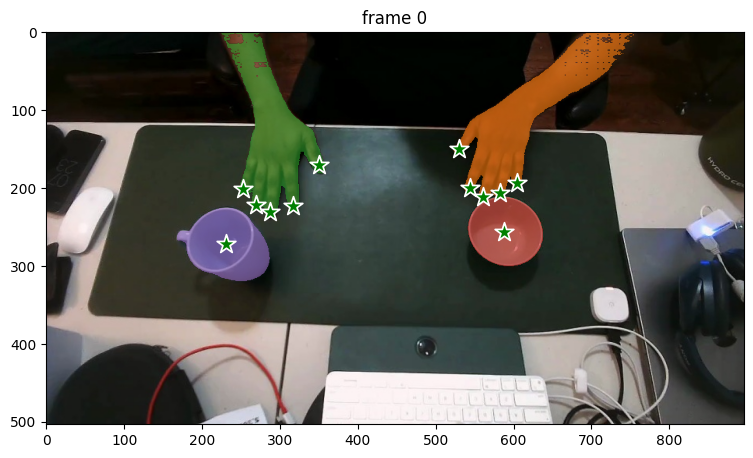

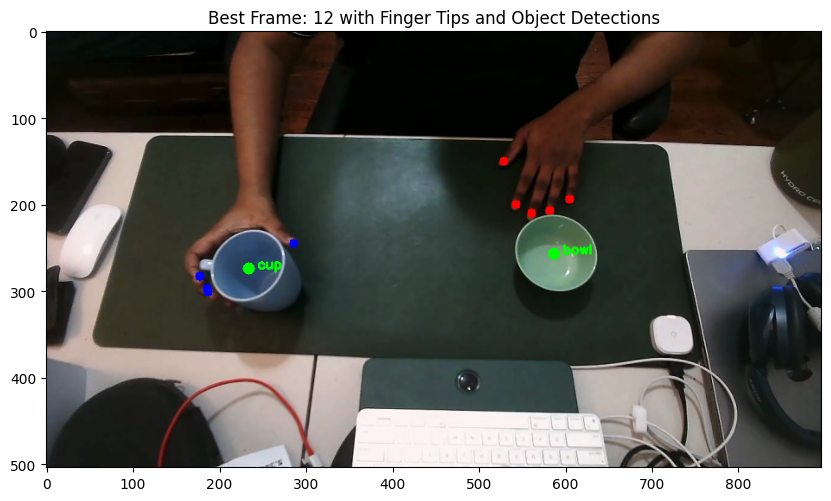

frame loading (JPEG): 100%|██████████| 18/18 [00:00<00:00, 33.77it/s]


[[587. 257.]] [1]
[[234. 274.]] [1]


propagate in video: 100%|██████████| 13/13 [01:47<00:00,  8.28s/it]


Video saved to output_video_Reach.mp4
Directory 'temp_frames_Reach' and all its contents have been deleted.
Directory 'Reach_dir' and all its contents have been deleted.
Idle2
Extracted 25 frames to Idle2_dir at 10 FPS.
Best Frame: 24
Total Detections: 3
Number of Hands Detected: 2
Number of Objects Detected: 1
Fingertip Positions for All Hands:
Hand 1 Fingertips: [(485.9514881372452, 393.70263892412186), (511.8412141799927, 427.0272408723831), (525.4299105405807, 430.92534935474396), (543.4384860992432, 428.9861685037613), (556.255518078804, 418.5707997083664)]
Hand 2 Fingertips: [(329.9568992257118, 417.3321006298065), (326.98712682724, 433.30039924383163), (320.8263700604439, 442.28512555360794), (311.734310567379, 440.79089373350143), (303.2155264019966, 431.81301414966583)]
Detected Objects:
bowl: Center coordinates = (347, 439), Confidence = 0.77
Successfully loaded best frame: Idle2_dir/0024.jpg
Hand 1 Finger Tips Coordinates:
[(485.9514881372452, 393.70263892412186), (511.84121

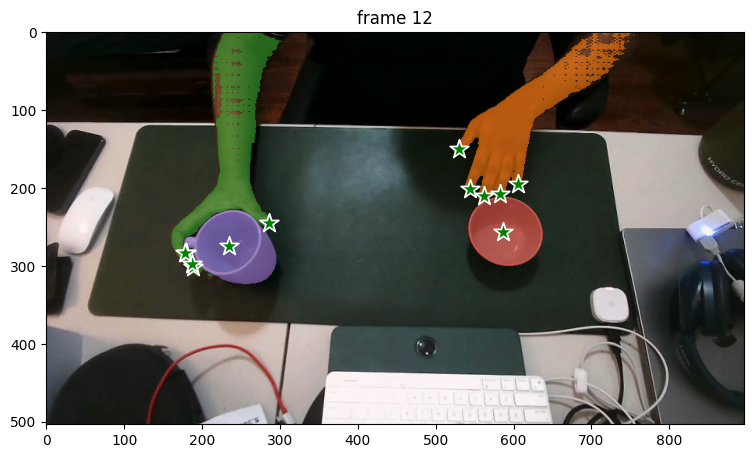

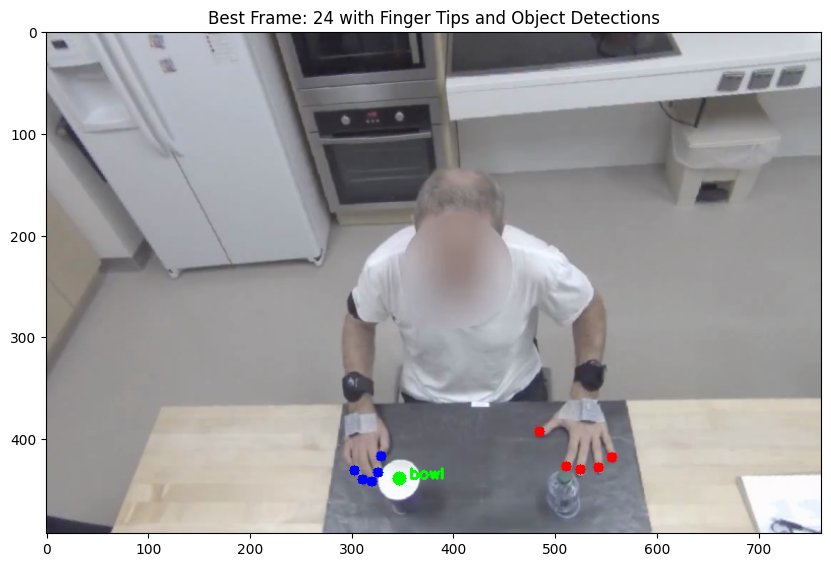

frame loading (JPEG): 100%|██████████| 25/25 [00:00<00:00, 27.56it/s]


[[347. 439.]] [1]


propagate in video: 100%|██████████| 25/25 [03:01<00:00,  7.25s/it]


Video saved to output_video_Idle2.mp4
Directory 'temp_frames_Idle2' and all its contents have been deleted.
Directory 'Idle2_dir' and all its contents have been deleted.
Reach2
Extracted 18 frames to Reach2_dir at 10 FPS.
Best Frame: 14
Total Detections: 3
Number of Hands Detected: 2
Number of Objects Detected: 1
Fingertip Positions for All Hands:
Hand 1 Fingertips: [(509.4731719493866, 406.0244241952896), (549.2934612035751, 438.59103775024414), (553.7180185317993, 435.7289006114006), (560.9741617441177, 432.3294571042061), (569.4821816682816, 425.2253765463829)]
Hand 2 Fingertips: [(327.05486887693405, 419.7088842391968), (320.4149444103241, 438.74839490652084), (314.3663492202759, 442.73974227905273), (306.0645530819893, 438.75156849622726), (297.3296211361885, 429.6123059988022)]
Detected Objects:
bowl: Center coordinates = (344, 442), Confidence = 0.58
Successfully loaded best frame: Reach2_dir/0014.jpg
Hand 1 Finger Tips Coordinates:
[(509.4731719493866, 406.0244241952896), (549.

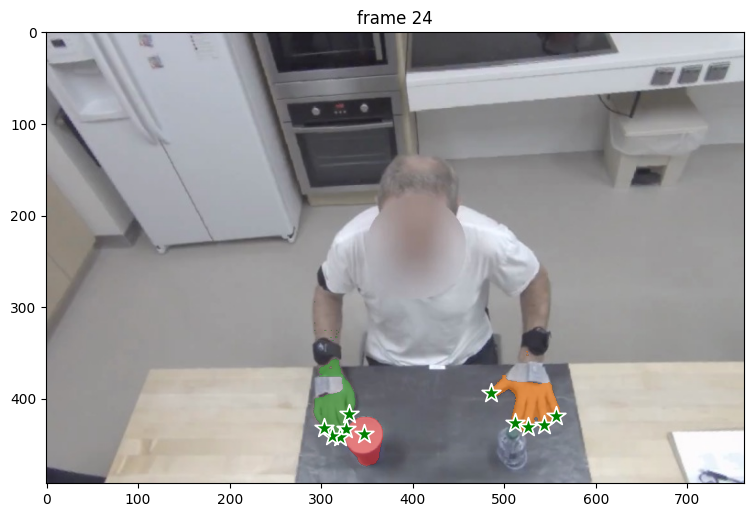

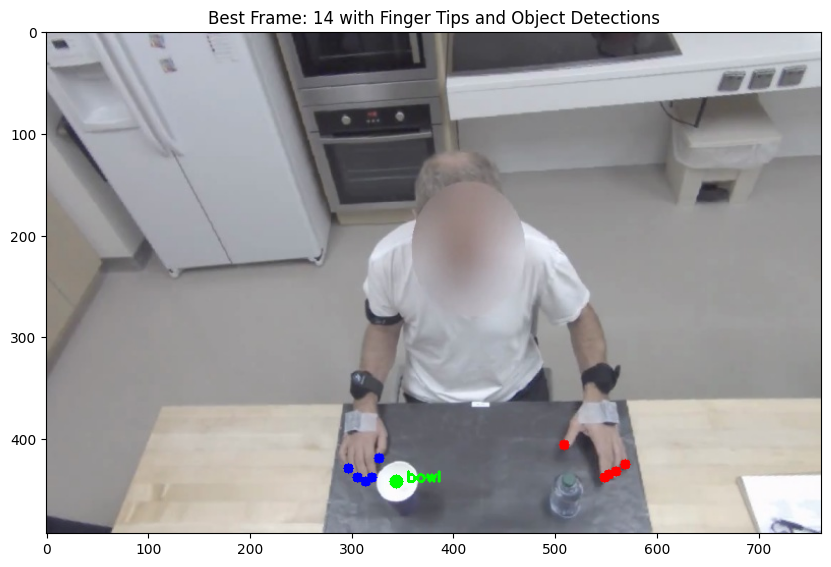

frame loading (JPEG): 100%|██████████| 18/18 [00:00<00:00, 39.77it/s]


[[344. 442.]] [1]


propagate in video: 100%|██████████| 15/15 [01:45<00:00,  7.04s/it]


Video saved to output_video_Reach2.mp4
Directory 'temp_frames_Reach2' and all its contents have been deleted.
Directory 'Reach2_dir' and all its contents have been deleted.


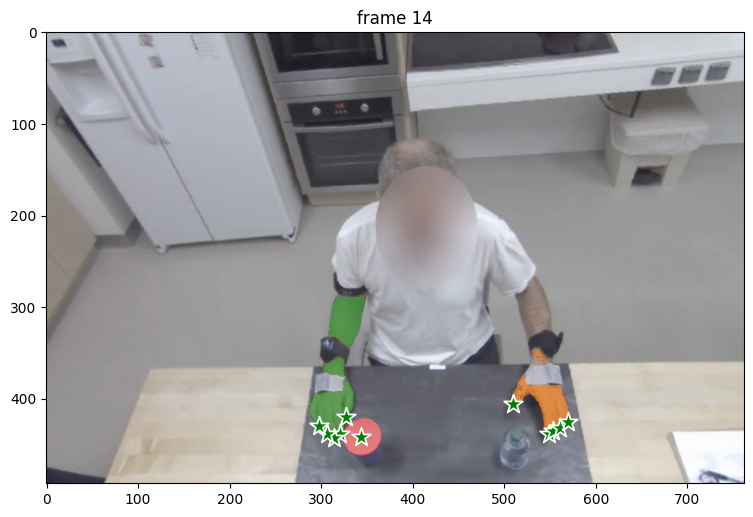

In [7]:
primitives_dir_path = '../Primitives'
segment_data = {}
# Iterate through the directory
for filename in os.listdir(primitives_dir_path):
    # Check if the file is an mp4 file
    if filename.endswith('.mp4'):
        # Print the file name
        filename = os.path.splitext(filename)[0]
        print(filename)
        
        video_path = f'../Primitives/{filename}.mp4'
        output_video_path = f"output_video_{filename}.mp4"
        temp_frame_dir = f"temp_frames_{filename}"
        sam2_checkpoint = "./checkpoints/sam2.1_hiera_large.pt"
        model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
        scale_factor = 0.7
        target_fps = 10
        video_name = os.path.splitext(os.path.basename(video_path))[0]
        video_dir = f"{video_name}_dir"
        
        extract_all_frames(video_path, video_dir, target_fps, scale_factor)

        frame_files = sorted(glob.glob(os.path.join(video_dir, '*.jpg')))  # Assuming frames are in jpg format
        if not frame_files:
            raise ValueError("No frames found in the specified directory.")
        
        frame_count = 0
        best_frame_number = -1
        best_fingertip_positions = []
        best_confidence = 0
        max_hands_detected = 0
        total_current = 0 
        # Read frames from the directory
        for frame_file in frame_files:
            frame = cv2.imread(frame_file)
            if frame is None:
                continue

            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = hands.process(frame_rgb)

            hands_detected = 0
            all_fingertip_positions = []
            hand_confidence = 0

            if results.multi_hand_landmarks:
                hands_detected = len(results.multi_hand_landmarks)
                for hand_landmarks in results.multi_hand_landmarks:
                    fingertip_indices = [4, 8, 12, 16, 20]
                    
                    visibility_scores = [landmark.visibility for landmark in hand_landmarks.landmark]
                    average_visibility = sum(visibility_scores) / len(visibility_scores)

                    handedness = results.multi_handedness[0]
                    handedness_confidence = handedness.classification[0].score

                    confidence = (average_visibility + handedness_confidence) / 2
                    hand_confidence += confidence

                    fingertip_positions = []
                    for idx in fingertip_indices:
                        x = hand_landmarks.landmark[idx].x * frame.shape[1]
                        y = hand_landmarks.landmark[idx].y * frame.shape[0]
                        fingertip_positions.append((x, y))

                    all_fingertip_positions.append(fingertip_positions)

            # Object detection
            blob = cv2.dnn.blobFromImage(frame, 1/255.0, (416, 416), swapRB=True, crop=False)
            net.setInput(blob)
            outputs = net.forward(layer_names)

            boxes = []
            confidences = []
            class_ids = []
            height, width = frame.shape[:2]

            for output in outputs:
                for detection in output:
                    scores = detection[5:]
                    class_id = np.argmax(scores)
                    confidence = scores[class_id]
                    if confidence > 0.5 and class_id in target_class_ids:
                        center_x, center_y, w, h = (detection[:4] * np.array([width, height, width, height])).astype('int')
                        x = int(center_x - w/2)
                        y = int(center_y - h/2)
                        boxes.append([x, y, int(w), int(h)])
                        confidences.append(float(confidence))
                        class_ids.append(class_id)

            indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
            
            object_detections = []
            object_confidence = sum(confidences) / len(confidences) if confidences else 0

            if boxes:
                for i in indices.flatten():
                    x, y, w, h = boxes[i]
                    label = classes[class_ids[i]]
                    confidence = confidences[i]
                    center_x = x + w // 2
                    center_y = y + h // 2
                    object_detections.append((label, (center_x, center_y), confidence))

            # Calculate overall confidence
            overall_confidence = (hand_confidence / max(1, hands_detected) + object_confidence) / 2

            # Calculate total detections
            total_detections = hands_detected + len(indices)

            # Update best frame if necessary
            if total_detections > total_current or (total_detections == total_current and overall_confidence > best_confidence):
                best_confidence = overall_confidence
                best_frame_number = frame_count
                best_fingertip_positions = all_fingertip_positions
                total_current = total_detections
                best_object_detections = object_detections

            frame_count += 1

        # Output the details of the best frame
        if best_frame_number != -1:
            print(f"Best Frame: {best_frame_number}")
            print(f"Total Detections: {total_current}")
            print(f"Number of Hands Detected: {len(best_fingertip_positions)}")
            print(f"Number of Objects Detected: {len(best_object_detections)}")
            print(f"Fingertip Positions for All Hands:")
            for i, fingertips in enumerate(best_fingertip_positions):
                print(f"Hand {i+1} Fingertips: {fingertips}")
            print(f"Detected Objects:")
            for obj in best_object_detections:
                print(f"{obj[0]}: Center coordinates = {obj[1]}, Confidence = {obj[2]:.2f}")
        else:
            print("No hands or objects detected in any frame.")

        # Load the best frame from the directory
        best_frame_filename = f'{video_dir}/{best_frame_number:04d}.jpg'  # Assuming frame numbers are zero-padded
        best_frame = cv2.imread(best_frame_filename)

        if best_frame is None:
            print(f"Error: Could not load the best frame {best_frame_filename}")
        else:
            print(f"Successfully loaded best frame: {best_frame_filename}")

        # Copy the best frame to overlay the fingertip points and object detections
        overlay_image = best_frame.copy()

        # Display the fingertip points for each hand
        for hand_index, fingertips in enumerate(best_fingertip_positions):
            for (x, y) in fingertips:
                x, y = int(x), int(y)  # Explicitly convert to integers
                # Choose color based on hand (Red for Hand 1, Blue for Hand 2, etc.)
                color = (0, 0, 255) if hand_index == 0 else (255, 0, 0)  # Red for Hand 1, Blue for Hand 2
                cv2.circle(overlay_image, (x, y), radius=5, color=color, thickness=-1)

            # Print the coordinates of the fingertip points
            print(f"Hand {hand_index + 1} Finger Tips Coordinates:")
            print(fingertips)

        # Display the detected objects as singular points
        for obj in best_object_detections:
            label, (center_x, center_y), confidence = obj
            center_x, center_y = int(center_x), int(center_y)  # Explicitly convert to integers
            color = (0, 255, 0)  # Green color for object detections
            cv2.circle(overlay_image, (center_x, center_y), radius=7, color=color, thickness=-1)
            cv2.putText(overlay_image, label, (center_x + 10, center_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

            # Print the coordinates of the detected objects
            print(f"{label} Coordinates: ({center_x}, {center_y}), Confidence: {confidence:.2f}")

        # Visualize the results using matplotlib
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))
        plt.title(f"Best Frame: {best_frame_number} with Finger Tips and Object Detections")
        plt.show()

        # scan all the JPEG frame names in this directory
        frame_names = [
            p for p in os.listdir(video_dir)
            if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
        ]
        frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

        predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

        inference_state = predictor.init_state(video_path=video_dir)
        predictor.reset_state(inference_state)

        ann_frame_idx = best_frame_number  # the frame index we interact with
        ann_obj_id= 1 
        prompts = {}

        # Check if there are fingertip positions for Hand 1
        if len(best_fingertip_positions) > 0:
            hand1_finger_tips = best_fingertip_positions[0]  # Assuming Hand 1 is the first hand in the list
            
            if len(hand1_finger_tips) > 0:
                points = np.array(hand1_finger_tips, dtype=np.float32)
                # For labels, `1` means positive click and `0` means negative click
                labels = np.ones(len(hand1_finger_tips), dtype=np.int32)
                
                # Store the points and labels in the prompts dictionary
                prompts[ann_obj_id] = points, labels
                
                # Call predictor.add_new_points_or_box() with the updated points and labels for Hand 1
                _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
                    inference_state=inference_state,
                    frame_idx=ann_frame_idx,
                    obj_id=ann_obj_id,
                    points=points,
                    labels=labels,
                )
                ann_obj_id+=1

        # Check if there are fingertip positions for Hand 2
        if len(best_fingertip_positions) > 1:
            hand2_finger_tips = best_fingertip_positions[1]  # Assuming Hand 2 is the second hand in the list
            
            if len(hand2_finger_tips) > 0:
                points = np.array(hand2_finger_tips, dtype=np.float32)
                # For labels, `1` means positive click and `0` means negative click
                labels = np.ones(len(hand2_finger_tips), dtype=np.int32)
                
                # Store the points and labels in the prompts dictionary
                prompts[ann_obj_id] = points, labels
                
                # Call predictor.add_new_points_or_box() with the updated points and labels for Hand 2
                _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
                    inference_state=inference_state,
                    frame_idx=ann_frame_idx,
                    obj_id=ann_obj_id,
                    points=points,
                    labels=labels,
                )
                ann_obj_id+=1

        for obj in best_object_detections:
            label, (center_x, center_y), confidence = obj

            points = np.array([[center_x, center_y]], dtype=np.float32)
            # For labels, `1` means positive click and `0` means negative click
            labels = np.ones(1, dtype=np.int32)
            print(points, labels)
            # Store the points and labels in the prompts dictionary
            prompts[ann_obj_id] = points, labels
            
            # Call predictor.add_new_points_or_box() with the updated points and labels for objects
            _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
                inference_state=inference_state,
                frame_idx=ann_frame_idx,
                obj_id=ann_obj_id,
                points=points,
                labels=labels,
            )
            ann_obj_id+=1


        # show the results on the current (interacted) frame
        plt.figure(figsize=(9, 6))
        plt.title(f"frame {ann_frame_idx}")
        plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
        for i, out_obj_id in enumerate(out_obj_ids):
            show_points(*prompts[out_obj_id], plt.gca())
            show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

        video_segments_forward = {}
        for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state, start_frame_idx=ann_frame_idx):
            video_segments_forward[out_frame_idx] = {
                out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
                for i, out_obj_id in enumerate(out_obj_ids)
            }

        # Propagate backward in time (from ann_frame_idx to the start of the video)
        video_segments_backward = {}
        for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state, start_frame_idx=ann_frame_idx, reverse=True):
            video_segments_backward[out_frame_idx] = {
                out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
                for i, out_obj_id in enumerate(out_obj_ids)
            }

        # Combine forward and backward results
        video_segments = {**video_segments_backward, **video_segments_forward}



        os.makedirs(temp_frame_dir, exist_ok=True)

        # List to store the paths of the generated frames
        frame_paths = []

        for out_frame_idx in range(0, len(frame_names)):
            # Open the original image
            original_image = Image.open(os.path.join(video_dir, frame_names[out_frame_idx]))
            
            # Convert the image to grayscale
            grayscale_image = original_image.convert('L')
            
            # Convert PIL image to numpy array for OpenCV processing
            grayscale_np = np.array(grayscale_image)
            
            # Apply Gaussian blur
            blurred_image = cv2.GaussianBlur(grayscale_np, (15, 15), 0)
            
            plt.figure(figsize=(6, 4))
            plt.title(f"frame {out_frame_idx}")
            plt.imshow(blurred_image, cmap='gray')
            
            for out_obj_id, out_mask in video_segments[out_frame_idx].items():
                show_mask(out_mask, plt.gca(), obj_id=out_obj_id)
            
            # Save the frame with the mask applied
            frame_path = os.path.join(temp_frame_dir, f"frame_{out_frame_idx:04d}.png")
            plt.savefig(frame_path)
            plt.close()
            
            # Append the frame path to the list
            frame_paths.append(frame_path)

        # Compile the frames into a video
        with imageio.get_writer(output_video_path, fps=target_fps) as writer:
            for frame_path in frame_paths:
                image = imageio.imread(frame_path)
                writer.append_data(image)

        print(f"Video saved to {output_video_path}")

        if os.path.exists(temp_frame_dir):
            # Delete the directory and all its contents
            shutil.rmtree(temp_frame_dir)
            print(f"Directory '{temp_frame_dir}' and all its contents have been deleted.")
        else:
            print(f"Directory '{temp_frame_dir}' does not exist.")

        if os.path.exists(video_dir):
            # Delete the directory and all its contents
            shutil.rmtree(video_dir)
            print(f"Directory '{video_dir}' and all its contents have been deleted.")
        else:
            print(f"Directory '{video_dir}' does not exist.")

        segment_data[filename] = video_segments

In [8]:
import pickle

# Save to a pickle file
with open('../output.pkl', 'wb') as file:
    pickle.dump(segment_data, file)

In [9]:
with open('../output.pkl', 'rb') as file:
    loaded_data = pickle.load(file)
print(loaded_data)

{'Reposition2': {4: {1: array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]]), 2: array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]]), 3: array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [Fals

In [10]:
def extract_node_features(video_segments):
    nodes = []
    for frame_idx, objects in video_segments.items():
        for obj_id, mask in objects.items():
            size = np.sum(mask)
            position = np.argwhere(mask)
            if position.size > 0:
                x, y, z = position.mean(axis=0)
            else:
                x, y, z = 0, 0
            node_features = [obj_id, x, y, z, size]
            nodes.append(node_features)
    return nodes

from scipy.spatial.distance import euclidean

def calculate_edges(node_features, distance_threshold=5):
    edges = []
    edge_attributes = []

    for i in range(len(node_features)):
        for j in range(i + 1, len(node_features)):
            distance = euclidean(node_features[i][1:4], node_features[j][1:4])  # Using x, y, z
            if distance < distance_threshold:
                edges.append([i, j])
                edges.append([j, i])
                edge_attributes.append([distance])
                edge_attributes.append([distance])

    return edges, edge_attributes

In [11]:
import os
import torch
from torch_geometric.data import Data, DataLoader

def construct_graph(node_features, edges, edge_attributes):
    x = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attributes, dtype=torch.float)
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

def prepare_data(segment_data, video_dir):
    graph_data_list = []
    for filename, segments in segment_data.items():
        node_features = extract_node_features(segments)
        edges, edge_attributes = calculate_edges(node_features)
        graph = construct_graph(node_features, edges, edge_attributes)
        graph_data_list.append(graph)
    
    return graph_data_list

# Assuming segment_data is your dictionary with filenames as keys
graph_data_list = prepare_data(loaded_data, primitives_dir_path)
loader = DataLoader(graph_data_list, batch_size=1, shuffle=True)


/Users/sudharshanramesh/Studies/Curiosity_New/HandTracker/myenv/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [18]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCAE(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(GCAE, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels // 2)
        self.conv3 = GCNConv(hidden_channels // 2, 5)  # 5 dimensions for 5 clusters
        
        self.conv4 = GCNConv(5, hidden_channels // 2)
        self.conv5 = GCNConv(hidden_channels // 2, hidden_channels)
        self.conv6 = GCNConv(hidden_channels, num_features)

    def encode(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        return self.conv3(x, edge_index)

    def decode(self, z, edge_index):
        z = F.relu(self.conv4(z, edge_index))
        z = F.relu(self.conv5(z, edge_index))
        return self.conv6(z, edge_index)

    def forward(self, x, edge_index):
        z = self.encode(x, edge_index)
        x_hat = self.decode(z, edge_index)
        return z, x_hat

# Initialize the model
num_features = graph_data_list[0].num_node_features
hidden_channels = 64
model = GCAE(num_features, hidden_channels)



In [19]:
import torch.optim as optim
from sklearn.cluster import KMeans

optimizer = optim.Adam(model.parameters(), lr=0.01)

def train(model, loader, num_epochs=100):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for data in loader:
            optimizer.zero_grad()
            z, x_hat = model(data.x, data.edge_index)
            loss = F.mse_loss(x_hat, data.x)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {total_loss / len(loader)}')

train(model, loader)



def get_embeddings(model, loader):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for data in loader:
            z, _ = model(data.x, data.edge_index)
            embeddings.append(z.mean(dim=0).numpy())
    return np.array(embeddings)

embeddings = get_embeddings(model, loader)

# Perform K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

# Map filenames to cluster labels
filename_to_cluster = {filename: label for filename, label in zip(segment_data.keys(), cluster_labels)}


Epoch 0, Loss: 14223765.194444444
Epoch 10, Loss: 114744.96875
Epoch 20, Loss: 101388.11827256944
Epoch 30, Loss: 98244.94550238716
Epoch 40, Loss: 97879.8727484809
Epoch 50, Loss: 297721.9576822917
Epoch 60, Loss: 156306.90017361112
Epoch 70, Loss: 107408.77750651042
Epoch 80, Loss: 106112.99343532986
Epoch 90, Loss: 97658.39740668403


In [22]:
filename_to_cluster

{'Reposition2': 4,
 'Reposition3': 1,
 'Stabilize': 2,
 'Transport': 0,
 'Reposition': 1,
 'Idle': 3,
 'Reach': 1,
 'Idle2': 1,
 'Reach2': 2}

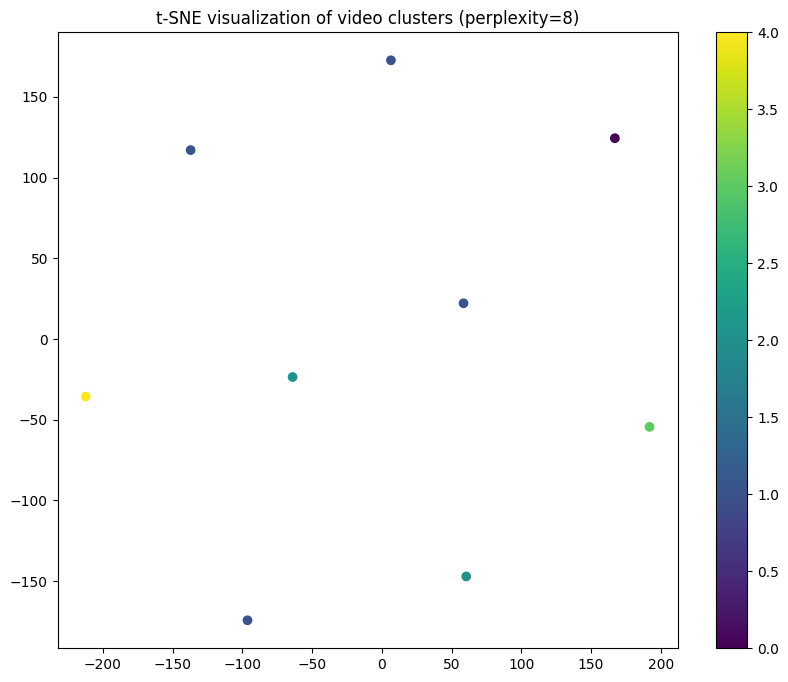

In [21]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Get the number of samples
n_samples = len(embeddings)

# Choose a perplexity value less than n_samples
perplexity = min(30, n_samples - 1)  # Default is 30, but we ensure it's less than n_samples

# If n_samples is very small, further reduce perplexity
if n_samples < 10:
    perplexity = max(2, n_samples - 1)  # Minimum perplexity is 2

tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='viridis')
plt.colorbar(scatter)
plt.title(f't-SNE visualization of video clusters (perplexity={perplexity})')
plt.show()


In [31]:
exit()

: 